In [34]:
from pylab import *
from pyspark.sql import SparkSession
import pandas as pd
import seaborn as sns
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

%matplotlib inline

# The purpose of this notebook is to introduce myself to PySpark while predicting Life Expectancy

## Life Expectancy Data from [link](https://www.kaggle.com/kumarajarshi/life-expectancy-who#Life%20Expectancy%20Data.csv "Title")

## This data set includes information on the location, age, and a number of health indicators for people all over the globe

### The variables are:	
- Country
- Year
- Status:Developed or Developing status
- Life expectancy
- Adult Mortality: probability of dying between 15 and 60 years per 1000 population
- infant deaths: Number of Infant Deaths per 1000 population
- Alcohol: recorded per capita (15+) consumption (in litres of pure alcohol)
- percentage expenditure: Expenditure on health as a percentage of Gross Domestic Product per capita(%)
- Hepatitis B: (HepB) immunization coverage among 1-year-olds (%)
- Measles: number of reported cases per 1000 population
- BMI: Average Body Mass Index of entire population
- under-five deaths: Number of under-five deaths per 1000 population
- Polio: (Pol3) immunization coverage among 1-year-olds (%)
- Total expenditure: General government expenditure on health as a percentage of total government expenditure (%)
- Diphtheria: Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)
- HIV/AIDS: Deaths per 1 000 live births HIV/AIDS (0-4 years)
- GDP: Gross Domestic Product per capita (in USD)
- Population: Population of the country
- thinness 1-19 years: Prevalence of thinness among children and adolescents for Age 10 to 19 (% )
- thinness 5-9 years: Prevalence of thinness among children for Age 5 to 9(%)
- Income composition of resources: Human Development Index in terms of income composition of resources (index ranging from 0 to 1)
- Schooling: Number of years of Schooling(years)


# First, load and visualize the data

In [2]:
#Start spark and load the data
spark = SparkSession.builder.appName('LifeExpectancy').getOrCreate()

df = spark.read.csv('Life Expectancy Data.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- Life expectancy : double (nullable = true)
 |-- Adult Mortality: integer (nullable = true)
 |-- infant deaths: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- percentage expenditure: double (nullable = true)
 |-- Hepatitis B: integer (nullable = true)
 |-- Measles : integer (nullable = true)
 |--  BMI : double (nullable = true)
 |-- under-five deaths : integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- Total expenditure: double (nullable = true)
 |-- Diphtheria : integer (nullable = true)
 |--  HIV/AIDS: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Population: double (nullable = true)
 |--  thinness  1-19 years: double (nullable = true)
 |--  thinness 5-9 years: double (nullable = true)
 |-- Income composition of resources: double (nullable = true)
 |-- Schooling: double (nullable = true)



In [3]:
#Rename messy columns
oldCol = ['Life expectancy ','Adult Mortality', 'infant deaths',\
          'percentage expenditure','Hepatitis B','Measles ', \
         ' BMI ','under-five deaths ', 'Total expenditure', \
         'Diptheria ',' HIV/AIDS',' thinness  1-19 years',\
         ' thinness 5-9 years','Income composition of resources']

newCol = ['LifeExpectancy','AdultMortality','InfantDeaths',\
         'PercentExpenditure','HepB','Measles','BMI',\
         'Under5Deaths','TotalExpenditure','Diptheria','HIV_AIDS',\
         'thinness1_19','thinness5_9','IncomeComposition']

df = reduce(lambda data, idx: data.withColumnRenamed(oldCol[idx], newCol[idx]), xrange(len(oldCol)), df)
df.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- LifeExpectancy: double (nullable = true)
 |-- AdultMortality: integer (nullable = true)
 |-- InfantDeaths: integer (nullable = true)
 |-- Alcohol: double (nullable = true)
 |-- PercentExpenditure: double (nullable = true)
 |-- HepB: integer (nullable = true)
 |-- Measles: integer (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Under5Deaths: integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- TotalExpenditure: double (nullable = true)
 |-- Diphtheria : integer (nullable = true)
 |-- HIV_AIDS: double (nullable = true)
 |-- GDP: double (nullable = true)
 |-- Population: double (nullable = true)
 |-- thinness1_19: double (nullable = true)
 |-- thinness5_9: double (nullable = true)
 |-- IncomeComposition: double (nullable = true)
 |-- Schooling: double (nullable = true)



In [4]:
#transpose so we can see all columns
pd.DataFrame(df.take(5), columns=df.columns).T

,0,1,2,3,4
Country,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
Year,2015,2014,2013,2012,2011
Status,Developing,Developing,Developing,Developing,Developing
LifeExpectancy,65,59.9,59.9,59.5,59.2
AdultMortality,263,271,268,272,275
InfantDeaths,62,64,66,69,71
Alcohol,0.01,0.01,0.01,0.01,0.01
PercentExpenditure,71.2796,73.5236,73.2192,78.1842,7.09711
HepB,65,62,64,67,68
Measles,1154,492,430,2787,3013


In [5]:
#Check balance of developing/developed
df.groupby('Status').count().toPandas()

,Status,count
0,Developed,512
1,Developing,2426


In [6]:
#Summary of numeric variables, everything except Country and Status
numericvar = [vv[0] for vv in df.dtypes if (vv[1]=='int') or (vv[1]=='double')]
pddf = df.toPandas() #skip year
pddf.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,2938.0,2.007519e+03,4.613841e+00,2000.00000,2004.000000,2.008000e+03,2.012000e+03,2.015000e+03
LifeExpectancy,2928.0,6.922493e+01,9.523867e+00,36.30000,63.100000,7.210000e+01,7.570000e+01,8.900000e+01
AdultMortality,2928.0,1.647964e+02,1.242921e+02,1.00000,74.000000,1.440000e+02,2.280000e+02,7.230000e+02
InfantDeaths,2938.0,3.030395e+01,1.179265e+02,0.00000,0.000000,3.000000e+00,2.200000e+01,1.800000e+03
Alcohol,2744.0,4.602861e+00,4.052413e+00,0.01000,0.877500,3.755000e+00,7.702500e+00,1.787000e+01
PercentExpenditure,2938.0,7.382513e+02,1.987915e+03,0.00000,4.685343,6.491291e+01,4.415341e+02,1.947991e+04
HepB,2385.0,8.094046e+01,2.507002e+01,1.00000,77.000000,9.200000e+01,9.700000e+01,9.900000e+01
Measles,2938.0,2.419592e+03,1.146727e+04,0.00000,0.000000,1.700000e+01,3.602500e+02,2.121830e+05
BMI,2904.0,3.832125e+01,2.004403e+01,1.00000,19.300000,4.350000e+01,5.620000e+01,8.730000e+01
Under5Deaths,2938.0,4.203574e+01,1.604455e+02,0.00000,0.000000,4.000000e+00,2.800000e+01,2.500000e+03


## Check out the distributions of the features, and how they correlate with Life Expectancy

Peak in LE around 75


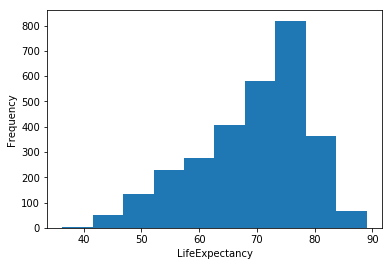

As # of people who make it to adulthood goes down, so does LE


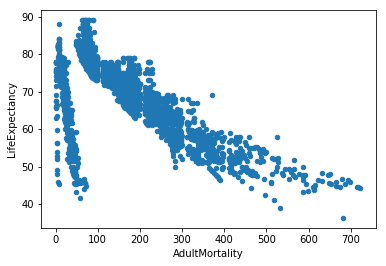

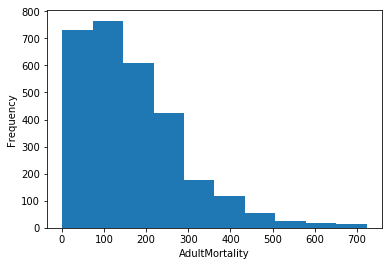

Some outlying trends in infant deaths, where do they come from?


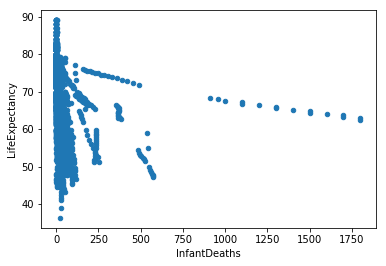

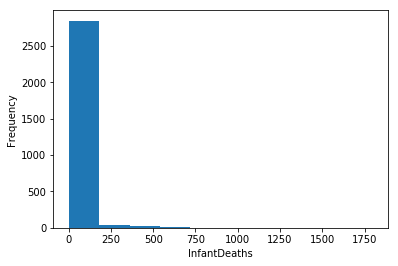

Alcohol usage doesn't seem very correlated with LE


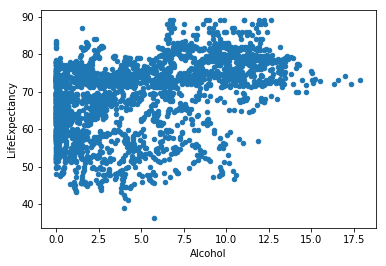

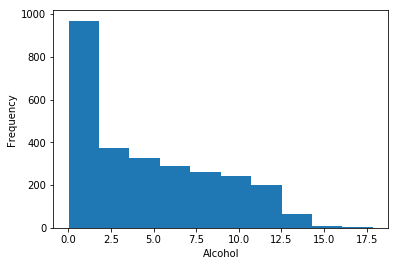

Higher spending == higher LE, but lower spending is all over


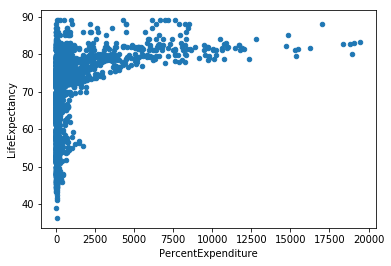

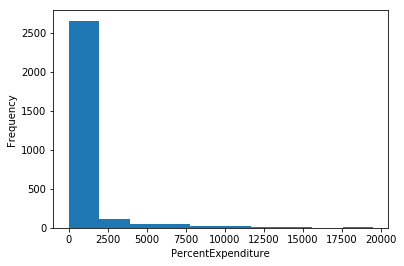

HepB vaccine doesn't look very correlated with LE


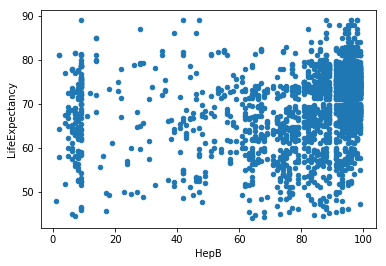

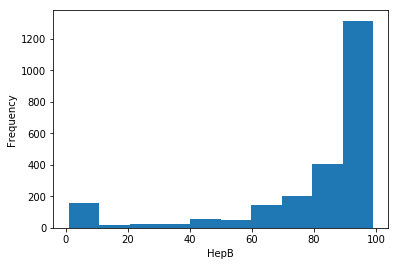

Amount of people with measles doesn't look very correlated with LE


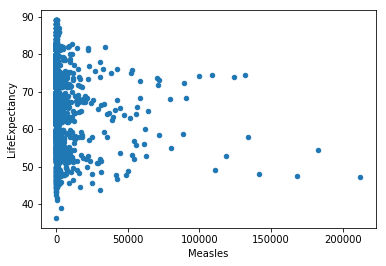

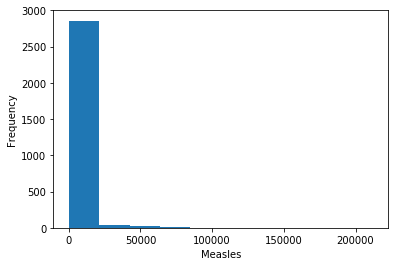

Higher BMI looks correlated with LE, hmm...
What is that group of extremely low BMI?


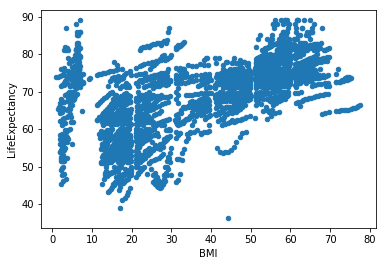

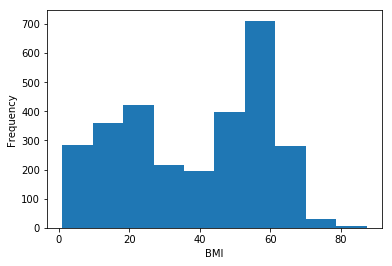

Under 5 deaths has similar weirdness to infant deaths, what's up?


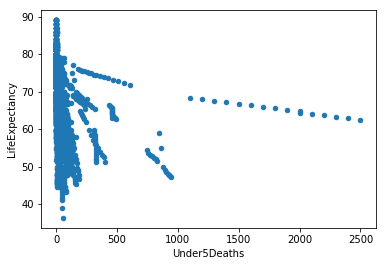

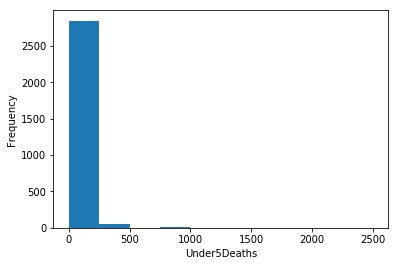

In general, more people vaccinated against polio means higher LE
What is the group of low vacciantions?


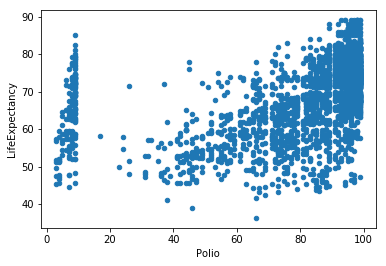

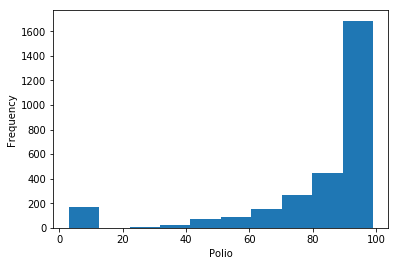

Percentage of total govt expenditure is not very correlated with LE


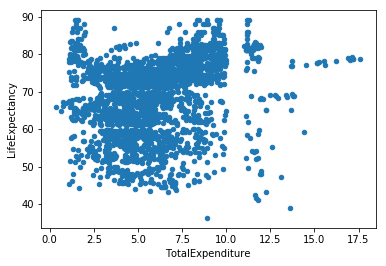

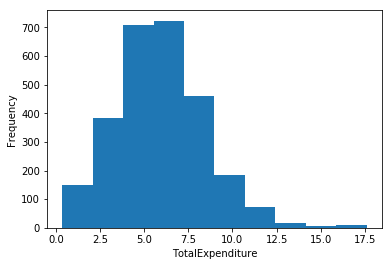

More DPT vaccinations means longer LE


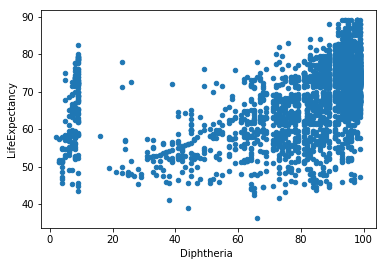

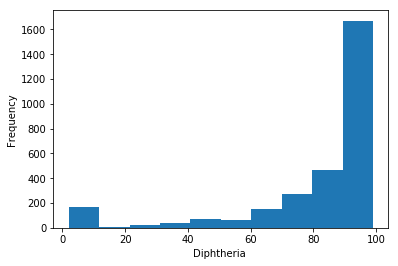

Less HIV/AIDS means longer LE


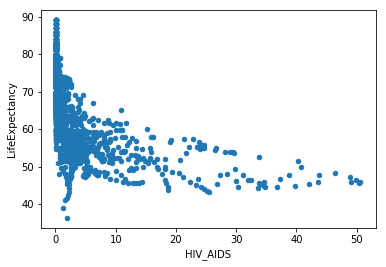

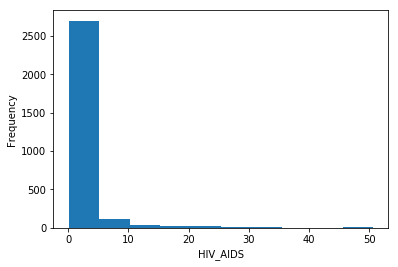

There is a relation in GDP and LE


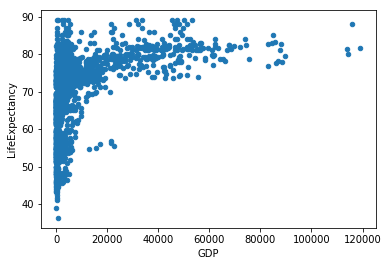

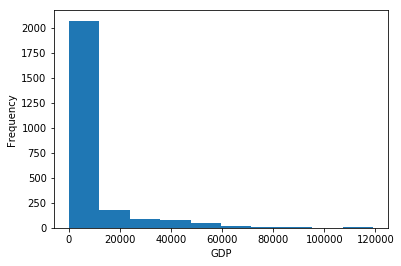

Would there be a correlation if ignoring those outliers?


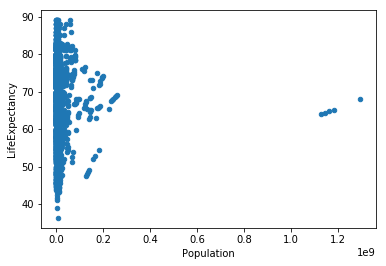

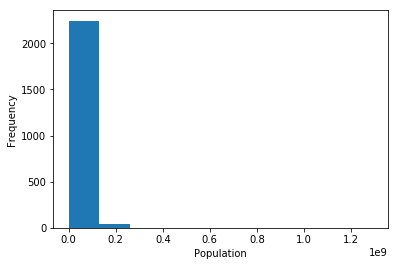

Prevalence of thinness seems slightly correlated


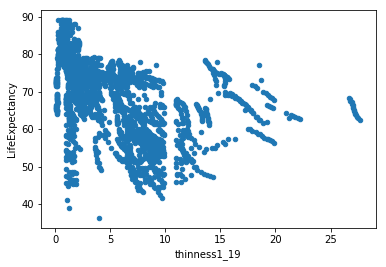

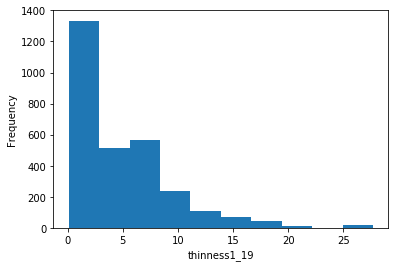

Prevalence of thinness seems slightly correlated


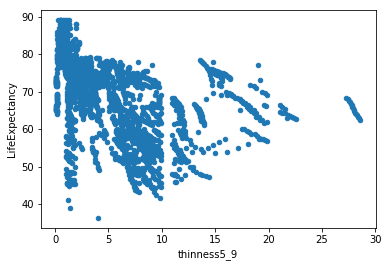

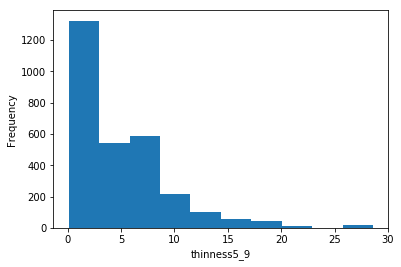

Index composition highly correlated with LE.
What is that group of 0 IC?


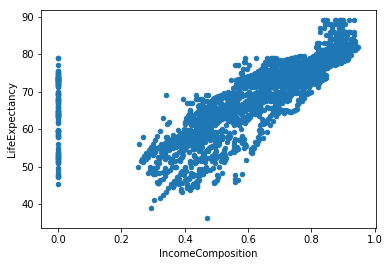

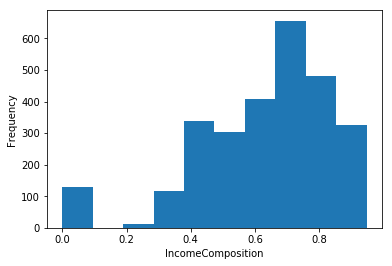

Schooling highly correlated with LE


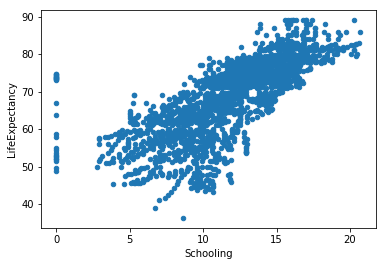

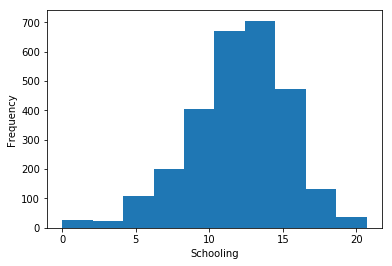

In [7]:
observations = [
    'Peak in LE around 75', \
    'As # of people who make it to adulthood goes down, so does LE',\
    'Some outlying trends in infant deaths, where do they come from?',\
    'Alcohol usage doesn\'t seem very correlated with LE',\
    'Higher spending == higher LE, but lower spending is all over',\
    'HepB vaccine doesn\'t look very correlated with LE',\
    'Amount of people with measles doesn\'t look very correlated with LE',\
    'Higher BMI looks correlated with LE, hmm...\nWhat is that group of extremely low BMI?',\
    'Under 5 deaths has similar weirdness to infant deaths, what\'s up?',\
    'In general, more people vaccinated against polio means higher LE\nWhat is the group of low vacciantions?',\
    'Percentage of total govt expenditure is not very correlated with LE',\
    'More DPT vaccinations means longer LE',\
    'Less HIV/AIDS means longer LE',\
    'There is a relation in GDP and LE',\
    'Would there be a correlation if ignoring those outliers?',\
    'Prevalence of thinness seems slightly correlated',\
    'Prevalence of thinness seems slightly correlated',\
    'Index composition highly correlated with LE.\nWhat is that group of 0 IC?',\
    'Schooling highly correlated with LE'
]

print(observations[0])
pddf['LifeExpectancy'].plot.hist()
xlabel('LifeExpectancy')
plt.show()

for ii,vv in enumerate(numericvar[2:]): #life expectancy and year
    print observations[ii+1]
    pddf.plot.scatter(x=vv,y='LifeExpectancy')
    figure()
    pddf[vv].plot.hist()
    xlabel(vv)
    plt.show()

In [8]:
#more visualizations to look more closely at some things

Higher infant mortality means lower LE
But where do these linear relations come from?
Noticed later they're a time series for each country


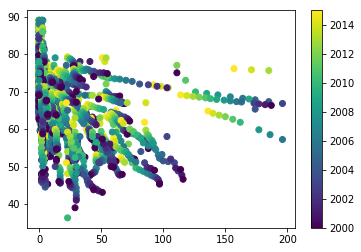

In [9]:
mask = pddf.InfantDeaths<=200
plotx = pddf.InfantDeaths[mask]
ploty = pddf.LifeExpectancy[mask]
scatter(plotx,ploty,c=pddf.Year[mask])
colorbar()
print 'Higher infant mortality means lower LE\nBut where do these linear relations come from?'
print 'Noticed later they\'re a time series for each country'

Measles still does not look correlated


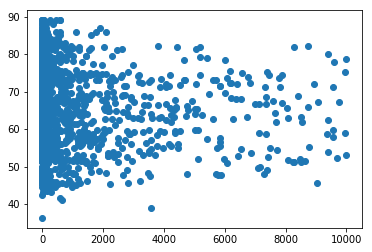

In [10]:
mask = pddf.Measles<=10000
plotx = pddf.Measles[mask]
ploty = pddf.LifeExpectancy[mask]
scatter(plotx,ploty)
print 'Measles still does not look correlated'

283 Should probably get rid of these, average BMI that low seems erroneous


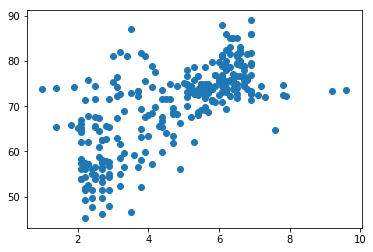

In [11]:
mask = pddf.BMI<=10
plotx = pddf.BMI[mask]
ploty = pddf.LifeExpectancy[mask]
scatter(plotx,ploty)
print sum(mask), 'Should probably get rid of these, average BMI that low seems erroneous'
pddf[mask].T
pddf=pddf[pddf.BMI>=10]

151 I think the case for all the vaccines is there is a group of developing countries with low vaccination rates, but a range in LE.


,0,11,48,59,60,63,104,127,153,157,...,2713,2722,2781,2807,2868,2900,2906,2909,2913,2934
Country,Afghanistan,Afghanistan,Angola,Angola,Angola,Angola,Armenia,Australia,Azerbaijan,Azerbaijan,...,Tuvalu,Uganda,United Republic of Tanzania,United States of America,Venezuela (Bolivarian Republic of),Yemen,Zambia,Zambia,Zambia,Zimbabwe
Year,2015,2004,2015,2004,2003,2000,2007,2000,2006,2002,...,2013,2007,2012,2002,2005,2005,2015,2012,2008,2003
Status,Developing,Developing,Developing,Developing,Developing,Developing,Developing,Developed,Developing,Developing,...,Developing,Developing,Developing,Developed,Developing,Developing,Developing,Developing,Developing,Developing
LifeExpectancy,65,57,52.4,47.1,46.8,45.3,73.5,79.5,69.2,67.8,...,NaN,55.5,58.6,77,73.6,62.6,61.8,59.2,55.7,44.5
AdultMortality,263,293,335,386,388,48,132,78,154,146,...,NaN,41,348,115,158,245,33,349,45,715
InfantDeaths,62,87,66,94,95,97,1,1,6,7,...,0,88,87,28,9,40,27,29,31,26
Alcohol,0.01,0.02,NaN,3.53,3.49,1.85,3.99,10.17,0.85,0.55,...,0.01,9.65,3.98,8.33,7.92,0.04,NaN,2.59,2.12,4.06
PercentExpenditure,71.2796,15.2961,0,8.86678,35.9335,15.8815,44.5722,347.187,105.634,39.3325,...,78.2812,6.00253,0,0,0,0,0,196.915,153.678,0
HepB,65,67,64,NaN,NaN,NaN,85,NaN,52,5,...,9,73,92,88,88,8,9,78,87,7
Measles,1154,466,118,29,1196,2219,1,108,222,4353,...,0,3776,1668,41,0,6285,9,896,140,998


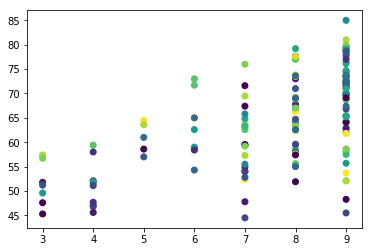

In [12]:
mask = pddf.Polio<=10
plotx = pddf.Polio[mask]
ploty = pddf.LifeExpectancy[mask]
scatter(plotx,ploty,c=pddf.Year[mask])
print sum(mask), 'I think the case for all the vaccines is there is a group of developing countries with low vaccination rates, but a range in LE.'
pddf[mask].T

In [13]:
pddf[mask].groupby('Status').count()

,Country,Year,LifeExpectancy,AdultMortality,InfantDeaths,Alcohol,PercentExpenditure,HepB,Measles,BMI,...,Polio,TotalExpenditure,Diphtheria,HIV_AIDS,GDP,Population,thinness1_19,thinness5_9,IncomeComposition,Schooling
Status,,,,,,,,,,,,,,,,,,,,,
Developed,5,5,5,5,5,5,5,2,5,5,...,5,5,5,5,4,4,5,5,4,4
Developing,146,146,145,145,146,136,146,113,146,146,...,146,132,146,146,124,126,146,146,135,136


931 Not much correlation


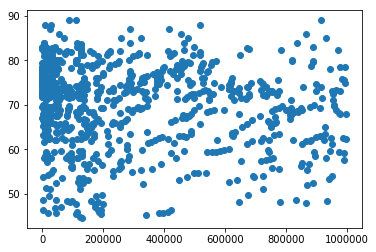

In [14]:
mask = pddf.Population<=0.1e7
plotx = pddf.Population[mask]
ploty = pddf.LifeExpectancy[mask]
scatter(plotx,ploty)
print sum(mask), 'Not much correlation'

16 Looks like each line is a time series for each country


,Country,Year,Status,LifeExpectancy,AdultMortality,InfantDeaths,Alcohol,PercentExpenditure,HepB,Measles,...,Polio,TotalExpenditure,Diphtheria,HIV_AIDS,GDP,Population,thinness1_19,thinness5_9,IncomeComposition,Schooling
1186,India,2015,Developing,68.3,181.0,910,NaN,0.000000,87.0,90387,...,86.0,NaN,87.0,0.2,1613.188780,1.395398e+06,26.7,27.3,0.615,11.6
1187,India,2014,Developing,68.0,184.0,957,3.07,86.521539,79.0,79563,...,84.0,4.69,85.0,0.2,1573.118890,1.293859e+09,26.8,27.4,0.607,11.6
1188,India,2013,Developing,67.6,187.0,1000,3.11,67.672304,7.0,13822,...,82.0,4.53,83.0,0.2,1452.195373,1.278562e+08,26.8,27.5,0.599,11.5
1189,India,2012,Developing,67.3,19.0,1100,3.10,64.969645,73.0,18668,...,79.0,4.39,82.0,0.2,1446.985410,1.263659e+08,26.9,27.6,0.590,11.3
1190,India,2011,Developing,66.8,193.0,1100,3.00,64.605901,44.0,33634,...,79.0,4.33,82.0,0.2,1461.671957,1.247236e+08,26.9,27.7,0.580,10.8
1191,India,2010,Developing,66.4,196.0,1200,2.77,57.733599,38.0,31458,...,76.0,4.28,79.0,0.2,1345.771530,1.239869e+07,27.0,27.8,0.569,10.4
1192,India,2009,Developing,66.0,2.0,1300,2.50,0.844186,37.0,56188,...,73.0,4.38,74.0,0.2,19.317765,1.214271e+08,27.0,27.8,0.563,10.5
1193,India,2008,Developing,65.5,23.0,1300,1.93,43.030433,29.0,44258,...,69.0,4.34,7.0,0.3,991.484634,1.197147e+08,27.0,27.9,0.556,10.2
1194,India,2007,Developing,65.2,26.0,1400,1.59,5.234770,6.0,41144,...,67.0,4.23,64.0,0.3,118.166373,1.179681e+09,27.1,28.0,0.546,9.9
1195,India,2006,Developing,64.8,28.0,1500,1.37,34.859427,6.0,64185,...,66.0,4.25,65.0,0.3,792.259698,1.161978e+09,27.1,28.0,0.536,9.7


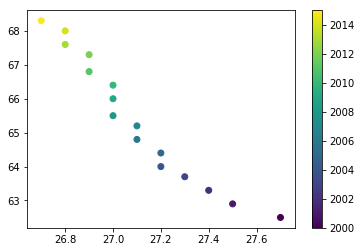

In [15]:
mask = pddf.thinness1_19>=25
plotx = pddf.thinness1_19[mask]
ploty = pddf.LifeExpectancy[mask]
scatter(plotx,ploty,c=pddf.Year[mask])
colorbar()
print sum(mask), 'Looks like each line is a time series for each country'
pddf[mask]

106 There are countries with truly 0 for IC


,Country,Year,Status,LifeExpectancy,AdultMortality,InfantDeaths,Alcohol,PercentExpenditure,HepB,Measles,...,Polio,TotalExpenditure,Diphtheria,HIV_AIDS,GDP,Population,thinness1_19,thinness5_9,IncomeComposition,Schooling
74,Antigua and Barbuda,2005,Developing,74.6,147.0,0,8.15,1455.608186,99.0,0,...,98.0,4.41,99.0,0.1,11371.938950,NaN,3.5,3.4,0.0,0.0
77,Antigua and Barbuda,2002,Developing,74.0,153.0,0,7.21,927.407585,99.0,0,...,93.0,4.41,98.0,0.1,9386.716452,NaN,3.6,3.5,0.0,0.0
78,Antigua and Barbuda,2001,Developing,73.8,154.0,0,7.51,163.767698,96.0,0,...,99.0,4.48,97.0,0.1,9358.154162,NaN,3.6,3.5,0.0,0.0
79,Antigua and Barbuda,2000,Developing,73.6,156.0,0,7.27,1127.743470,NaN,0,...,96.0,4.13,95.0,0.1,9875.161736,NaN,3.7,3.6,0.0,0.0
175,Bahamas,2000,Developing,72.6,192.0,0,12.15,0.000000,NaN,0,...,91.0,5.21,99.0,0.1,NaN,NaN,2.7,2.6,0.0,12.0
294,Bhutan,2009,Developing,67.4,232.0,1,0.17,27.489070,93.0,6,...,93.0,6.30,93.0,0.4,177.234497,714458.0,16.8,17.5,0.0,10.9
295,Bhutan,2008,Developing,67.0,234.0,1,0.21,302.667579,96.0,7,...,96.0,6.58,96.0,0.4,1795.181370,795.0,17.1,17.8,0.0,10.5
296,Bhutan,2007,Developing,66.5,238.0,1,0.16,283.806236,95.0,11,...,93.0,5.88,95.0,0.3,1741.142552,686958.0,17.3,18.1,0.0,10.1
297,Bhutan,2006,Developing,65.8,245.0,1,0.29,169.202397,95.0,2,...,96.0,5.27,95.0,0.3,1335.456960,672228.0,17.5,18.3,0.0,9.6
298,Bhutan,2005,Developing,65.0,254.0,1,0.73,145.596544,95.0,11,...,95.0,5.28,95.0,0.3,1247.613920,656639.0,17.8,18.6,0.0,9.2


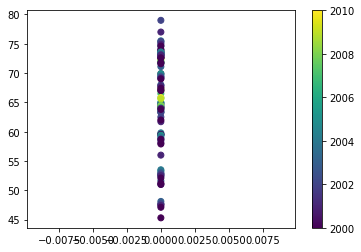

In [16]:
mask = pddf.IncomeComposition<=0.1
plotx = pddf.IncomeComposition[mask]
ploty = pddf.LifeExpectancy[mask]
scatter(plotx,ploty,c=pddf.Year[mask])
colorbar()
print sum(mask), 'There are countries with truly 0 for IC'
pddf[mask]

15 There are countries with truly 0 for schooling


,Country,Year,Status,LifeExpectancy,AdultMortality,InfantDeaths,Alcohol,PercentExpenditure,HepB,Measles,...,Polio,TotalExpenditure,Diphtheria,HIV_AIDS,GDP,Population,thinness1_19,thinness5_9,IncomeComposition,Schooling
74,Antigua and Barbuda,2005,Developing,74.6,147.0,0,8.15,1455.608186,99.0,0,...,98.0,4.41,99.0,0.1,11371.938950,NaN,3.5,3.4,0.0,0.0
77,Antigua and Barbuda,2002,Developing,74.0,153.0,0,7.21,927.407585,99.0,0,...,93.0,4.41,98.0,0.1,9386.716452,NaN,3.6,3.5,0.0,0.0
78,Antigua and Barbuda,2001,Developing,73.8,154.0,0,7.51,163.767698,96.0,0,...,99.0,4.48,97.0,0.1,9358.154162,NaN,3.6,3.5,0.0,0.0
79,Antigua and Barbuda,2000,Developing,73.6,156.0,0,7.27,1127.743470,NaN,0,...,96.0,4.13,95.0,0.1,9875.161736,NaN,3.7,3.6,0.0,0.0
335,Bosnia and Herzegovina,2000,Developing,74.6,116.0,0,3.64,165.616864,NaN,43,...,87.0,7.90,85.0,0.1,1461.755200,376676.0,3.3,3.2,0.0,0.0
849,Equatorial Guinea,2000,Developing,52.7,336.0,3,4.46,14.954513,NaN,0,...,41.0,2.73,34.0,1.9,172.684910,614323.0,1.7,1.6,0.0,0.0
1650,Marshall Islands,2013,Developing,NaN,NaN,0,0.01,871.878317,8.0,0,...,79.0,17.24,79.0,0.1,3617.752354,NaN,0.1,0.1,NaN,0.0
1714,Micronesia (Federated States of),2000,Developing,67.0,185.0,0,2.23,0.000000,87.0,0,...,85.0,7.88,85.0,0.1,NaN,NaN,0.3,0.3,0.0,0.0
1744,Montenegro,2003,Developing,73.5,134.0,0,0.01,495.078296,NaN,0,...,NaN,8.91,NaN,0.1,2789.173500,612267.0,2.4,2.4,0.0,0.0
1745,Montenegro,2002,Developing,73.4,136.0,0,0.01,36.480240,NaN,0,...,NaN,8.33,NaN,0.1,216.243274,69828.0,2.5,2.5,0.0,0.0


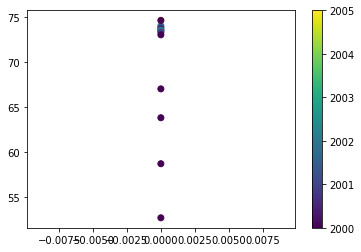

In [17]:
mask = pddf.Schooling<=1
plotx = pddf.Schooling[mask]
ploty = pddf.LifeExpectancy[mask]
scatter(plotx,ploty,c=pddf.Year[mask])
colorbar()
print sum(mask), 'There are countries with truly 0 for schooling'
pddf[mask]

In [18]:
#check out nans
pddf.isnull().sum()

Country                 0
Year                    0
Status                  0
LifeExpectancy          7
AdultMortality          7
InfantDeaths            0
Alcohol               161
PercentExpenditure      0
HepB                  493
Measles                 0
BMI                     0
Under5Deaths            0
Polio                   8
TotalExpenditure      190
Diphtheria              8
HIV_AIDS                0
GDP                   386
Population            579
thinness1_19            0
thinness5_9             0
IncomeComposition     144
Schooling             141
dtype: int64

In [19]:
mask = pddf.LifeExpectancy.isnull()
pddf[mask]
#looks like these don't have much info, drop

#for the rest, just replace with zeros

,Country,Year,Status,LifeExpectancy,AdultMortality,InfantDeaths,Alcohol,PercentExpenditure,HepB,Measles,...,Polio,TotalExpenditure,Diphtheria,HIV_AIDS,GDP,Population,thinness1_19,thinness5_9,IncomeComposition,Schooling
624,Cook Islands,2013,Developing,NaN,NaN,0,0.01,0.000000,98.0,0,...,98.0,3.58,98.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
769,Dominica,2013,Developing,NaN,NaN,0,0.01,11.419555,96.0,0,...,96.0,5.58,96.0,0.1,722.756650,NaN,2.7,2.6,0.721,12.7
1650,Marshall Islands,2013,Developing,NaN,NaN,0,0.01,871.878317,8.0,0,...,79.0,17.24,79.0,0.1,3617.752354,NaN,0.1,0.1,NaN,0.0
1812,Nauru,2013,Developing,NaN,NaN,0,0.01,15.606596,87.0,0,...,87.0,4.65,87.0,0.1,136.183210,NaN,0.1,0.1,NaN,9.6
1909,Niue,2013,Developing,NaN,NaN,0,0.01,0.000000,99.0,0,...,99.0,7.20,99.0,0.1,NaN,NaN,0.1,0.1,NaN,NaN
1958,Palau,2013,Developing,NaN,NaN,0,NaN,344.690631,99.0,0,...,99.0,9.27,99.0,0.1,1932.122370,292.0,0.1,0.1,0.779,14.2
2713,Tuvalu,2013,Developing,NaN,NaN,0,0.01,78.281203,9.0,0,...,9.0,16.61,9.0,0.1,3542.135890,1819.0,0.2,0.1,NaN,0.0


In [20]:
#drop nans
pddf2 = pddf.dropna(subset=['LifeExpectancy'])
df=df.filter(df.LifeExpectancy.isNotNull())

pddf2.fillna(0.,inplace=True)
df=df.fillna(0.)

df.printSchema()

/Users/brittanyfuzia/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


root
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- LifeExpectancy: double (nullable = false)
 |-- AdultMortality: integer (nullable = true)
 |-- InfantDeaths: integer (nullable = true)
 |-- Alcohol: double (nullable = false)
 |-- PercentExpenditure: double (nullable = false)
 |-- HepB: integer (nullable = true)
 |-- Measles: integer (nullable = true)
 |-- BMI: double (nullable = false)
 |-- Under5Deaths: integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- TotalExpenditure: double (nullable = false)
 |-- Diphtheria : integer (nullable = true)
 |-- HIV_AIDS: double (nullable = false)
 |-- GDP: double (nullable = false)
 |-- Population: double (nullable = false)
 |-- thinness1_19: double (nullable = false)
 |-- thinness5_9: double (nullable = false)
 |-- IncomeComposition: double (nullable = false)
 |-- Schooling: double (nullable = false)



In [21]:
#encode categorical data
catCols = ['Country','Status']
stages = []

for cc in catCols:
    si = StringIndexer(inputCol=cc, outputCol=cc+'Index')
    encoder = OneHotEncoderEstimator(inputCols=[si.getOutputCol()], outputCols=[cc+'classVec'])
    stages += [si, encoder]
    
assemblerInputs = [cc+"classVec" for cc in catCols] + numericvar
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')
stages+=[assembler]

#code from databricks' website
    

In [22]:
cols = df.columns
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['features'] + cols
df = df.select(selectedCols)
df.printSchema()


root
 |-- features: vector (nullable = true)
 |-- Country: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Status: string (nullable = true)
 |-- LifeExpectancy: double (nullable = false)
 |-- AdultMortality: integer (nullable = true)
 |-- InfantDeaths: integer (nullable = true)
 |-- Alcohol: double (nullable = false)
 |-- PercentExpenditure: double (nullable = false)
 |-- HepB: integer (nullable = true)
 |-- Measles: integer (nullable = true)
 |-- BMI: double (nullable = false)
 |-- Under5Deaths: integer (nullable = true)
 |-- Polio: integer (nullable = true)
 |-- TotalExpenditure: double (nullable = false)
 |-- Diphtheria : integer (nullable = true)
 |-- HIV_AIDS: double (nullable = false)
 |-- GDP: double (nullable = false)
 |-- Population: double (nullable = false)
 |-- thinness1_19: double (nullable = false)
 |-- thinness5_9: double (nullable = false)
 |-- IncomeComposition: double (nullable = false)
 |-- Schooling: double (nullable = false)



In [25]:
pd.DataFrame(df.take(5), columns=df.columns).T

,0,1,2,3,4
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
Country,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
Year,2015,2014,2013,2012,2011
Status,Developing,Developing,Developing,Developing,Developing
LifeExpectancy,65,59.9,59.9,59.5,59.2
AdultMortality,263,271,268,272,275
InfantDeaths,62,64,66,69,71
Alcohol,0.01,0.01,0.01,0.01,0.01
PercentExpenditure,71.2796,73.5236,73.2192,78.1842,7.09711
HepB,65,62,64,67,68


In [31]:
#split data into train/test
traindf, testdf = df.randomSplit([0.7, 0.3], seed = 2018)
print traindf.count(),testdf.count()

 2089 839


In [32]:
#gradient boosted tree regression
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'LifeExpectancy', maxIter=10)
gbt_model = gbt.fit(traindf)
gbt_predictions = gbt_model.transform(testdf)
gbt_predictions.select('prediction', 'LifeExpectancy', 'features').show(5)


+------------------+--------------+--------------------+
|        prediction|LifeExpectancy|            features|
+------------------+--------------+--------------------+
| 58.34673412482289|          58.9|(203,[0,182,183,1...|
|60.235754088525255|          59.3|(203,[0,182,183,1...|
| 46.98717103809734|          36.3|(203,[0,182,183,1...|
| 76.84497042253015|          77.2|(203,[1,183,184,1...|
| 77.80471714347092|          77.8|(203,[1,183,184,1...|
+------------------+--------------+--------------------+
only showing top 5 rows



In [35]:
gbt_evaluator = RegressionEvaluator(
    labelCol="LifeExpectancy", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)


Root Mean Squared Error (RMSE) on test data = 0.784108


In [38]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='LifeExpectancy', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(traindf)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9869857084789734,-0.0012078547660252514,0.0,0.005606199506995355,6.178123220141383e-06,0.0002109188449162394,0.0,0.0,0.0,0.0,0.0,0.0,-0.050204270707239505,0.0,0.0,0.0,0.0,0.2765055307957625,0.048587004823526736]
Intercept: 0.4321614913


In [39]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.433532
r2: 0.997956


In [46]:
lr_predictions = lr_model.transform(testdf)
lr_predictions.select("prediction","LifeExpectancy","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="LifeExpectancy",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))


+------------------+--------------+--------------------+
|        prediction|LifeExpectancy|            features|
+------------------+--------------+--------------------+
| 58.81389879449951|          58.9|(203,[0,182,183,1...|
|59.225547279206694|          59.3|(203,[0,182,183,1...|
| 35.92091941654707|          36.3|(203,[0,182,183,1...|
| 76.55123892506995|          77.2|(203,[1,183,184,1...|
| 77.14613854965488|          77.8|(203,[1,183,184,1...|
+------------------+--------------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.998265
